# LDA ( Latent Dirichlet Allocation):
<!-- + Jensen-Shannon distance -->
> LDA is used to classify text in a document to a particular topic. It builds a topic per document model and words per topic model, modeled as Dirichlet distributions.<br />
> Each document is modeled as a multinomial distribution of topics and each topic is modeled as a multinomial distribution of words.<br />
> LDA assumes that the every chunk of text we feed into it will contain words that are somehow related. Therefore choosing the right corpus of data is crucial.<br />
> It also assumes documents are produced from a mixture of topics. Those topics then generate words based on their probability distribution.

#### LDA has many uses:
- Understanding the different varieties topics in a corpus
- Getting a better insight into the type of documents in a corpus (whether they are about news, wikipedia articles, business documents)
- Quantifying the most used / most important words in a corpus
- and even document similarity and recommendation (here is we focus all our attention)

In [1]:
# import dependencies
%matplotlib inline
import pandas as pd
import nltk
import numpy as np
from nltk.corpus import stopwords
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim
import multiprocessing

from tqdm._tqdm_notebook import tqdm_notebook,tnrange,tqdm
from gensim.models.coherencemodel import CoherenceModel

sns.set_style("darkgrid")

# setting colwidth to 200; help in the visual analysis of sentences 
pd.set_option("display.max_colwidth", 200)
%matplotlib notebook
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

C:\Users\kaila\Anaconda3\envs\NLP_GPU_TF15\lib\site-packages\ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`


In [2]:
df_text = pd.read_csv('cleaned_data.csv', usecols=['lemmatized_description'], converters={'lemmatized_description': eval})
df_text.head(3)

,lemmatized_description
0,"[dubai, group, lead, al, qaeda, ally, abu, musab, al, zarqawi, say, behead, two, iraqi, soldier, broad, daylight, mosul, statement, find, islamist, web, site, friday, say]"
1,"[santa, monica, calif, star, video, game, industry, come, force, tuesday, night, honor, peer, creative, excellence, take, page, hollywood, playbook, red, carpet, glitter, gem, live, nationwide, br..."
2,"[ap, week, rally, marche, nearly, arrest, leave, anti, bush, protester, drain, city, refute, allegation, demonstrator, hold, long, police, custody]"


## LDA Model:
>- This function trains the lda model
>- We setup parameters like number of topics, the chunksize to use in Hoffman method
>- We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize

>- Unlike the word2vec algorithm, which performs extremely well with full structured sentences, 
>- LDA is a bag of words model, meaning word order in a document doesnt count. 
>- This also means that stopwords and rare words should be excluded, so that the model doesnt overcompensate for very frequent words and very rare words, both of which do not contribute to general topics.

### Training steps:
- Split the corpus into training and testing
- Here we will split the corpus into training and testing sets.

- The training set will be used to train the LDA model on, while the testing set will be used to retrieve similar articles later in our recommendation algorithm.

- The dataframe is already shuffled from the begining, so no need to do it again.

In [3]:
# create a mask of binary values
msk = np.random.rand(len(df_text)) < 0.99
msk

array([ True,  True,  True, ...,  True,  True,  True])

In [4]:
train_df = df_text[msk]
train_df.reset_index(drop=True,inplace=True)

test_df = df_text[~msk]
test_df.reset_index(drop=True,inplace=True)

In [5]:
print(len(df_text),len(train_df),len(test_df))

9993 9893 100


In [6]:
print(f'CPU cores:{multiprocessing.cpu_count()}')

CPU cores:12


### Creating Training Corpus:

In [7]:
dictionary = corpora.Dictionary(train_df['lemmatized_description'])
corpus = [dictionary.doc2bow(doc) for doc in train_df['lemmatized_description']]

In [8]:
def train_lda():   
    num_topics = 100
    chunksize = 3000
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, per_word_topics= True,
                              workers=12, alpha=1e-2, eta=0.5e-2, decay=0.5, 
                              chunksize=chunksize, passes=500, iterations=1000, eval_every=50)
    t2 = time.time()
    
    print(f"Time to train LDA model on {len(df_text)} articles: {round((t2-t1)/60, 2)} min")
    return dictionary,corpus,lda

### Hyperparameters:
1. `alpha` : low alpha means each document is only represented by a small number of topics, and vice versa
2. `eta`: low eta means each topic is only represented by a small number of words, and vice versa
3. `per_word_topics` : setting this to True allows for extraction of the most likely topics given a word. The training process is set in such a way that every word will be assigned to a topic. Otherwise, words that are not indicative are going to be omitted. phi_value is another parameter that steers this process - it is a threshold for a word treated as indicative or not.
4. `workers`: Parellel process nodes
5. `chunksize`: number of documents to consider at once
6. `passes`: how many times the algorithm is supposed to pass over the whole corpus

In [9]:
dictionary,corpus,lda = train_lda()

Time to train LDA model on 9993 articles: 24.18 min


### Let's inspect some topics!
- Word would be shortened (stemed) since we have done lemmatization

In [10]:
# show_topics method shows the the top num_words contributing to num_topics number of random topics
lda.show_topics(num_topics=5, num_words=20)

[(37,
  '0.049*"stock" + 0.026*"street" + 0.026*"company" + 0.025*"share" + 0.023*"co" + 0.021*"wall" + 0.021*"market" + 0.018*"earning" + 0.015*"japanese" + 0.015*"corp" + 0.014*"gain" + 0.014*"trading" + 0.013*"new" + 0.012*"wednesday" + 0.011*"business" + 0.011*"technology" + 0.011*"tokyo" + 0.010*"motor" + 0.010*"investor" + 0.009*"early"'),
 (82,
  '0.014*"panel" + 0.013*"one" + 0.010*"television" + 0.010*"two" + 0.009*"year" + 0.008*"last" + 0.008*"today" + 0.008*"beyond" + 0.007*"crystal" + 0.007*"week" + 0.006*"young" + 0.006*"vision" + 0.006*"call" + 0.006*"astronaut" + 0.006*"new" + 0.006*"campaign" + 0.005*"jury" + 0.005*"cooper" + 0.005*"liquid" + 0.005*"checkpoint"'),
 (7,
  '0.032*"manager" + 0.015*"mission" + 0.013*"say" + 0.011*"take" + 0.011*"good" + 0.008*"wednesday" + 0.008*"club" + 0.007*"half" + 0.007*"could" + 0.007*"new" + 0.007*"mark" + 0.007*"total" + 0.007*"xbox" + 0.006*"blackburn" + 0.006*"surface" + 0.006*"quit" + 0.006*"help" + 0.006*"ap" + 0.006*"newcastl

### We can inspect individual topics:
Below are word-probability pair for for the most relevant words generated by specific topic.

In [11]:
lda.show_topic(topicid=5, topn=20)

[('british', 0.083491765),
 ('london', 0.06468088),
 ('britain', 0.027377978),
 ('tony', 0.02483335),
 ('global', 0.022314502),
 ('blair', 0.019391153),
 ('say', 0.0162816),
 ('move', 0.012639324),
 ('project', 0.011433799),
 ('yesterday', 0.009137473),
 ('new', 0.009079472),
 ('century', 0.0089642415),
 ('could', 0.008944528),
 ('warming', 0.008165572),
 ('make', 0.008072999),
 ('doctor', 0.008067219),
 ('thursday', 0.00707215),
 ('announce', 0.0065716864),
 ('international', 0.006504975),
 ('satellite', 0.006276181)]

#### Above topic is about *`Olympic/Games`*

In [12]:
lda.show_topic(topicid=85, topn=20)

[('enterprise', 0.029268209),
 ('gold', 0.024252605),
 ('hat', 0.019581659),
 ('woman', 0.017342728),
 ('red', 0.016575115),
 ('linux', 0.011933088),
 ('go', 0.009419132),
 ('paula', 0.009098075),
 ('marathon', 0.009091916),
 ('field', 0.008657087),
 ('yesterday', 0.008481504),
 ('radcliffe', 0.008398623),
 ('harmony', 0.0076978584),
 ('email', 0.0062216534),
 ('bank', 0.00609791),
 ('mining', 0.0058647785),
 ('net', 0.005822499),
 ('rome', 0.0055977),
 ('distributor', 0.0055947765),
 ('twice', 0.005409031)]

#### Above topic is about *`Soccer/ Sport`*

In [13]:
lda.show_topic(topicid=0, topn=20)

[('president', 0.13119648),
 ('bush', 0.05980676),
 ('john', 0.03609417),
 ('french', 0.02233002),
 ('kerry', 0.021360543),
 ('campaign', 0.020680904),
 ('ap', 0.020642908),
 ('political', 0.016005486),
 ('call', 0.015715387),
 ('democratic', 0.015316206),
 ('house', 0.014804151),
 ('say', 0.0143405),
 ('afp', 0.012422234),
 ('iraq', 0.011265396),
 ('war', 0.011081598),
 ('vice', 0.010785715),
 ('white', 0.008342661),
 ('sen', 0.008216312),
 ('term', 0.007884358),
 ('take', 0.00758015)]

#### Above topic is about *`American football`*

In [14]:
lda.show_topic(topicid=50, topn=20)

[('fullquote', 0.06739697),
 ('n', 0.059033062),
 ('target', 0.05145677),
 ('com', 0.046690237),
 ('investor', 0.046466768),
 ('stock', 0.044561546),
 ('reuter', 0.04420615),
 ('http', 0.040105585),
 ('www', 0.039623894),
 ('href', 0.03939359),
 ('ticker', 0.038918898),
 ('quickinfo', 0.033698972),
 ('aspx', 0.033698972),
 ('new', 0.02438826),
 ('york', 0.020682424),
 ('inc', 0.018203055),
 ('say', 0.011619783),
 ('unitedstate', 0.010201114),
 ('quarterly', 0.008349225),
 ('co', 0.0072136642)]

#### Above topic is about *`Natural disaster`*

## Testing with train dataset:
#### Now, not only can we see the word contribution for each topic, but we can also visualise the topic contribution for each article.


In [15]:
random_article_index = np.random.randint(len(train_df['lemmatized_description']))
bow = dictionary.doc2bow(train_df['lemmatized_description'][random_article_index])
print(train_df['lemmatized_description'][random_article_index])
print(random_article_index)

['sport', 'india', 'cricket', 'chennai', 'oct', 'damien', 'martyn', 'crack', 'eighth', 'test', 'century', 'fourth', 'day', 'second', 'test', 'chidambaram', 'stadium', 'sunday', 'help', 'australia', 'set', 'india', 'target', 'win', 'match']
8996


In [16]:
# get the topic contributions for the document chosen at random above
doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)])

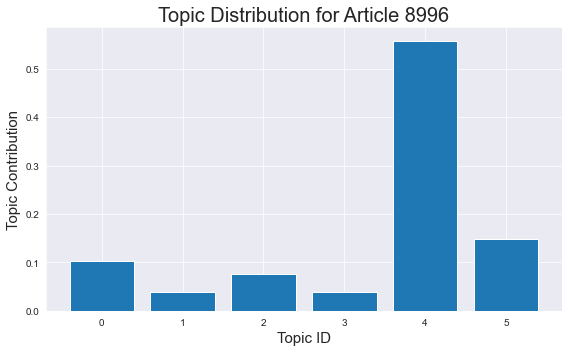

In [17]:
fig, ax = plt.subplots(figsize=(8,5));
# the histogram of the data
patches = ax.bar(np.arange(len(doc_distribution)), doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Article " + str(random_article_index), fontsize=20)
fig.tight_layout()
plt.show()

### The top 5 contributing topics and their words

In [18]:
for i in doc_distribution.argsort()[-10:]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

3 [('charge', 0.06494817), ('department', 0.042462602), ('meeting', 0.029177893), ('say', 0.025781736), ('we', 0.01852819), ('arrest', 0.016979381), ('justice', 0.01647752), ('prison', 0.015086807), ('year', 0.01422053), ('trial', 0.014219375)] 

1 [('agency', 0.050541375), ('nuclear', 0.03737825), ('iran', 0.036212005), ('news', 0.030802557), ('un', 0.029447585), ('say', 0.029087253), ('report', 0.020822963), ('program', 0.01992048), ('george', 0.016218746), ('w', 0.015810791)] 

2 [('say', 0.012822327), ('ebay', 0.012582172), ('content', 0.012511993), ('opportunity', 0.011118016), ('inc', 0.010994266), ('use', 0.008844616), ('internet', 0.0086274715), ('online', 0.008202864), ('solution', 0.00791061), ('south', 0.00772297)] 

0 [('president', 0.13119648), ('bush', 0.05980676), ('john', 0.03609417), ('french', 0.02233002), ('kerry', 0.021360543), ('campaign', 0.020680904), ('ap', 0.020642908), ('political', 0.016005486), ('call', 0.015715387), ('democratic', 0.015316206)] 

5 [('briti

In [19]:
vis = pyLDAvis.gensim.prepare(topic_model=lda, corpus=corpus, dictionary= dictionary, sort_topics=False)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

### From above we can interpret that:
The topics are about:
- online Search
- Law/court
- Space
- Award function
- Food industry

## Selecting a topic model & topics within it:
> In the example code given above, the number of topics was set to 12. But how did I chose this magic number 12? The hardest and the most elusive part of topic modeling is the selection of the number of topics.

Two important techniques used to evaluate topic models
1. `Perplexity` (might not be such a great measure):
    >- Given a trained model, perplexity tries to measure how this model is surprised when it is given a new dataset. This is measured as the normalized log-likelihood of the held out test set. The lower the perplexity, the better the model.<br />
    >- Calculates the log-likelihood; the probability of observing some unseen data given a model learned earlier. This checks whether the model captures the distribution of the held out set. If it doesn’t then the perplexity is very high suggesting that model is bad. However, studies have shown the following:
2. `Topic coherence`:
    >- Here we quantify the coherence of a topic by measuring the degree of semantic similarity between its high scoring words.T(hese measurements help distinguish between topics that are human interpretable and those that are artifacts of statistical inference.)
    >- To compute topic coherence of a topic model, we perform the following steps:
        1. Select the top n frequently occurring words in each topic
        2. Compute pairwise scores for each of the words selected above and aggregate all the pairwise scores to calculate the coherence score for a particular topic.
        3. Take a mean of the coherence score per topic for all topics in the model to arrive at a score for the topic model.
        

### 1. Perplexity
#### Select and article at random from test_df

In [20]:
random_article_index = np.random.randint(len(test_df))
print(random_article_index)

8


#### While working with test data:
- *In obtaining the BOW representation for this unseen article, gensim cleverly only considers words in the existing dictionary we used to train the model*
- *So if there are new words in this article, they will `not be considered` when infering the topic distribution.*
- *This is good in that no errors arise for unseen words,*
- *But bad in that some words may be cut out, and therefore we could miss out on an accurate topic distribution for this article.*

In [21]:
new_bow = dictionary.doc2bow(test_df['lemmatized_description'][random_article_index])

In [22]:
print(test_df['lemmatized_description'][random_article_index])


['ap', 'ibm', 'monday', 'launch', 'new', 'cheap', 'line', 'computer', 'server', 'design', 'small', 'business', 'production', 'plant']


In [23]:
new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=new_bow)])
new_doc_distribution

array([0.36561427, 0.0905816 , 0.08886807, 0.15629977, 0.11991471,
       0.11603114], dtype=float32)

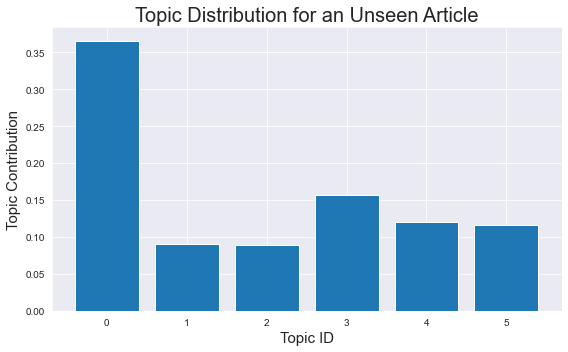

In [24]:
# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(8,5));
# the histogram of the data
patches = ax.bar(np.arange(len(new_doc_distribution)), new_doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for an Unseen Article", fontsize=20)
fig.tight_layout()
plt.show()

In [25]:
# print the top 8 contributing topics and their words
for i in new_doc_distribution.argsort()[-5:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

0 [('president', 0.13119648), ('bush', 0.05980676), ('john', 0.03609417), ('french', 0.02233002), ('kerry', 0.021360543), ('campaign', 0.020680904), ('ap', 0.020642908), ('political', 0.016005486), ('call', 0.015715387), ('democratic', 0.015316206)] 

3 [('charge', 0.06494817), ('department', 0.042462602), ('meeting', 0.029177893), ('say', 0.025781736), ('we', 0.01852819), ('arrest', 0.016979381), ('justice', 0.01647752), ('prison', 0.015086807), ('year', 0.01422053), ('trial', 0.014219375)] 

4 [('match', 0.04837418), ('final', 0.040785726), ('open', 0.029830692), ('tournament', 0.020251673), ('first', 0.016224686), ('champion', 0.015050373), ('china', 0.01388136), ('seed', 0.013617617), ('top', 0.012811389), ('wicket', 0.012651471)] 

5 [('british', 0.083491765), ('london', 0.06468088), ('britain', 0.027377978), ('tony', 0.02483335), ('global', 0.022314502), ('blair', 0.019391153), ('say', 0.0162816), ('move', 0.012639324), ('project', 0.011433799), ('yesterday', 0.009137473)] 

1 [(

### 2. Topic coherence

In [27]:
np.arange(3,26)

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25])

In [26]:
# Lda = models.LdaMulticore
coherenceList_umass = []
coherenceList_cv = []
num_topics_list = np.arange(3,26)
for num_topics in tqdm(num_topics_list):

#     lda= Lda(doc_term_matrix, num_topics=num_topics,id2word = dictionary, 
#              passes=20, chunksize=4000,random_state=43)
    dictionary,corpus,lda = train_lda()
    cm = CoherenceModel(model=lda, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    coherenceList_umass.append(cm.get_coherence())
    
#     cm_cv = CoherenceModel(model=lda, corpus=corpus, texts=skillList, dictionary=dictionary, coherence='c_v')
#     coherenceList_cv.append(cm_cv.get_coherence())
    vis = pyLDAvis.gensim.prepare(lda, doc_term_matrix, dictionary)

KeyboardInterrupt: 

In [ ]:
plotData = pd.DataFrame({'Number of topics':num_topics_list,
                         'CoherenceScore':coherenceList_umass})
f,ax = plt.subplots(figsize=(10,6))
sns.set_style("darkgrid")
sns.pointplot(x='Number of topics',y= 'CoherenceScore',data=plotData)
plt.axhline(y=-3.9)
plt.title('Topic coherence')
plt.savefig('Topic coherence plot.png')

## Similarity Query:
> Now that we have a topic distribution for a new unseen document, let's say we wanted to find the most similar documents in the corpus. We can do this by comparing the topic distribution of the new document to all the topic distributions of the documents in the corpus. We use the Jensen-Shannon distance metric to find the most similar documents.